In [5]:
import itertools
import pickle 
import networkx as nx
from dataloader import *
from collections import deque, defaultdict, Counter
from tqdm import tqdm
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import regex as re
import math
import nltk

In [2]:
with open("base_graph.pkl", 'rb') as f:
    G_directed = pickle.load(f)
f.close()
G = G_directed.to_undirected()

In [ ]:
'''
# compute the best partition
partition = community_louvain.best_partition(G)

# compute modularity
mod = community_louvain.modularity(partition, G)

number_of_communities = len(set(partition.values()))
print('Using the Louvain algortihm we identified', number_of_communities, 'communities')
'''

In [ ]:
#pickle.dump(partition, open( "partition.pkl", "wb" ) )
#pickle.dump(mod, open( "mod.pkl", "wb" ) )

In [3]:
with open("partition.pkl", 'rb') as f:
    partition = pickle.load(f)
    
with open("mod.pkl", 'rb') as f:
    mod = pickle.load(f)  
    
number_of_communities = len(set(partition.values()))


In [4]:
'''
community_dict[2] = [['27c5ea64-86cb-4e69-9d13-c8ba2654515d'],
 ['2ee9a087-6188-4ebd-95b9-6561cba0584c'],
 ['efe2dd1d-706c-4ab6-bd9b-90d35a81d04f']]
'''

community_dict = {new_list: [] for new_list in range(number_of_communities)}
for i, j in partition.items():  
    community_dict[j].append([i])
    
# Filter out communities with only one element
community_dict_bigger_than_one = {k: v for k, v in community_dict.items() if len(v) > 1}

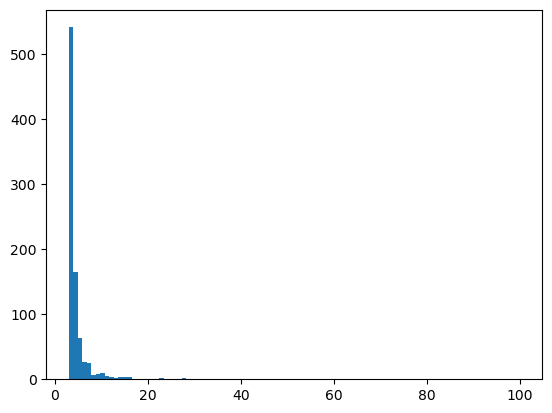

In [5]:
community_size = np.zeros(number_of_communities)

for i,j in enumerate(community_dict):
    community_size[i] = (len(community_dict[j]))
    
hist = plt.hist(community_size, bins=100, range=(3,100))

In [6]:
abstracts = nx.get_node_attributes(G, 'abstract')

In [7]:
#community_text = {i: ' '.join(abstracts[k] for j in community_dict[i] for k in j) for i in community_dict}#

In [10]:
#print(community_text[100])

We give an exponentially accurate normal form for a Lagrangian particle moving in a rotating shallow-water system in the semigeostrophic limit, which describes the motion in the region of an exponentially accurate slow manifold (a region of phase space for which dynamics on the fast scale are exponentially small in the Rossby number). We show how this result is related to the variational asymptotics approach of [M. Oliver, J. Fluid Mech., 551 (2006), pp. 197-234]; the difference is that on the Hamiltonian side it is possible to obtain strong bounds on the growth of fast motion away from (but close to) the slow manifold. Our normal form approach extends to numerical approximations via backward error analysis and extends to particle methods for the shallow-water equations, where the result shows that particles stay close to balance over long times in the semigeostrophic limit.


In [ ]:
community_text = {}
for i in community_dict:
    community_text[i] = ''
    for j in community_dict[i]:
        for k in j:
            community_text[i] = community_text[i] + abstracts[k]


In [7]:
def clean_and_tokenize(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    tokens = nltk.tokenize.word_tokenize(text)  # Tokenize text
    return tokens

# Apply the function to each text in community_text
community_text_clean = {i: clean_and_tokenize(text) for i, text in community_text.items()}

In [11]:
pickle.dump(community_text_clean, open( "community_text_clean.pkl", "wb" ) )

MemoryError: 

In [6]:
#pickle.dump(community_text, open( "community_text.pkl", "wb" ) )
with open("community_text.pkl", 'rb') as f:
    community_text = pickle.load(f)

In [12]:
'''
text_dict = {}

for i in community_text:
    no_punct = re.sub(r'[^\w\s]','',community_text[i])
    no_punct = re.sub(r'\n' , ' ', no_punct)
    no_punct = no_punct.lower()
    tokens = nltk.word_tokenize(no_punct)
    text_dict[i] = nltk.Text(tokens)
    
pickle.dump(text_dict, open( "text_dict.pkl", "wb"))
'''

In [8]:

#text_dict = {i: nltk.Text(nltk.word_tokenize(re.sub(r'[^\w\s]|[\n]', ' ', community_text[i]).lower())) for i in community_text}
#pickle.dump(text_dict, open("text_dict.pkl", "wb"))

with open("text_dict.pkl", 'rb') as f:
    text_dict = pickle.load(f)

In [12]:
# TF for each community
TF = {}
word_set = set()

for c in community_text:
    overall_freq = Counter()
    for i in community_text[c]:
        try:
            fd = nltk.FreqDist(text_dict[i])
            word_set.update(set(list(fd.keys())))
            overall_freq = overall_freq + Counter(fd)
        except:
            continue
    TF[c] = overall_freq

In [18]:
# TF for each community
TF = {}
word_set = set()
c = 2

overall_freq = Counter()
for i in community_text[c]:
    print('Yes')
    try:
        fd = nltk.FreqDist(text_dict[i])
        print(fd)
        word_set.update(set(list(fd.keys())))
        overall_freq = overall_freq + Counter(fd)
    except:
        print(i)
        continue
TF[c] = overall_freq

In [19]:
TF[2]

Counter()

In [13]:
pickle.dump(TF, open("TF.pkl", "wb"))

In [26]:
# TF for each community
TF = {}
word_set = set()
c = 2

overall_freq = Counter()
for i in community_text[c]:
    try:
        fd = nltk.FreqDist(text_dict[i])
        word_set.update(set(list(fd.keys())))
        overall_freq = overall_freq + Counter(fd)
    except:
        continue
TF[c] = overall_freq

In [ ]:
TF = {}
word_set = set()
c = 2

overall_freq = Counter()
for i in community_text.get(c, []):
    try:
        fd = nltk.FreqDist(text_dict[i])
        word_set.update(fd.keys())
        overall_freq += fd
    except Exception as e:
        print(f"Error processing document {i}: {e}")
        continue

TF[c] = overall_freq

In [27]:
TF[2]

Counter()

In [ ]:
# TF for each community
TF = defaultdict(Counter)
word_set = set()

for c in community_text:
    for i in community_text[c]:
        try:
            fd = nltk.FreqDist(text_dict[i])
            word_set.update(fd.keys())
            TF[c] += fd
        except:
            continue

In [11]:
def idf(word):
    occ = sum(1 for i in TF if word in TF[i])
    return np.log(10 / max(1, occ))

In [12]:
def tf_idf(number, com):    
    total_words = len(TF[number])
    return {word: (TF[number][word] / total_words) * idf(word) for word in com}

In [13]:
tf_idf_all_communities = [tf_idf(i, TF.get(i)) for i in TF]

In [16]:
tf_idf_all_communities

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},


In [17]:
def idf(word):
    occ = 0
    for i in TF:
        com = TF.get(i)
        if word in com.keys():
            occ += 1
    if occ == 0:
        occ = 1
    return np.log(10/occ)

In [18]:
def tf_idf(number, com):    
    vec = {}
    # Go through every word 
    for word in com.keys():

        # calculate the term frequency by dividing
        # the occurance of a certain word with the
        # total number of words in the commnity
        tf = TF[number][word]/len(TF[number])
        
        # calculates the inverse document frequency,
        idfreq = idf(word)

        # Then we multiply the two measures 
        val = tf*idfreq

        # save the result in a dictionary with the word
        # as the key and the TF-IDF score as the value
        vec[word] = val
    return vec

In [19]:
TF_IDF_all_communities = []
for i in TF:
    v = tf_idf(i, TF.get(i))
    TF_IDF_all_communities.append(v)

In [20]:
TF_IDF_all_communities


[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},


In [ ]:
TF = defaultdict(Counter)
word_set = set()

for i in community_text:
    # Join all sentences into a single string, then split and count
    overall_freq = Counter(' '.join(community_text[i]).split())
    TF[i] = overall_freq
    word_set |= set(TF[i].keys())

In [ ]:
DF = Counter()
for word in word_set:
    for i in community_text:
        if word in TF[i]:
            DF[word] += 1

# Calculate Inverse Document Frequency (IDF)
N = len(community_text)
IDF = {word: math.log(N / DF[word]) for word in DF}

In [ ]:
# Calculate TF-IDF
TF_IDF = {i: {word: TF[i][word] * IDF[word] for word in TF[i]} for i in community_text}